### Bayesian analysis

Based on the structure and variables in your dataset, **a Bayesian inference model is indeed possible and meaningful**—especially if your objective is to examine whether **cortisol and IgA features jointly predict attachment style** (i.e., Secure vs. Insecure). Although the dataset is small, Bayesian methods offer flexibility in low-data regimes by allowing incorporation of prior knowledge and yielding full posterior distributions rather than single-point estimates.


### Proposed Bayesian model

The appropriate model is a **Bayesian logistic regression**, modeling the probability of being Insecure (or Secure) as a function of cortisol and IgA:

$$
\text{Attachment}_i \sim \text{Bernoulli}(p_i)
$$

$$
\text{logit}(p_i) = \alpha + \beta_1 \cdot \text{Cortisol}_i + \beta_2 \cdot \text{IgA}_{\text{morning}, i} + \beta_3 \cdot \text{IgA}_{\text{afternoon}, i} + \beta_4 \cdot \text{IgA}_{\text{diff}, i}
$$

You can simplify the model by reducing collinearity (e.g., using only two IgA features), or expand it with interaction terms like cortisol × IgA.

---

### **Interpretation of the Model**

The posterior distributions of the β coefficients will inform you about:

* The **direction** and **magnitude** of each predictor’s effect.
* The **credibility intervals (HDI)** of the effects—i.e., how certain you are that a predictor increases or decreases the probability of insecure attachment.
* The potential **interplay between endocrine (cortisol) and immune (IgA)** systems in shaping attachment-related physiological profiles.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pymc as pm
import arviz as az

In [2]:
df_merge = pd.read_csv("../results_process/results_analysis_cortisol_iga_data.csv")
df_merge

,ID,Cortisol (pg/mL),Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment,Log-transformed Cortisol (pg/mL)
0,1,5.62,Male,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure,1.726332
1,5,2.28,Female,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure,0.824175
2,7,1.83,Female,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure,0.604316
3,16,3.59,Female,57.476955,73.891936,16.414980,3.974519,4.178677,0.204158,Secure,1.278152
4,23,4.76,Female,80.824884,47.632842,-33.192041,4.392023,3.846883,-0.545141,Secure,1.560248
5,27,2.26,Female,43.637360,37.759187,-15.388331,3.751583,3.631229,-0.120354,Secure,0.815365
6,32,22.75,Male,32.565326,44.611069,12.045743,3.417520,3.749981,0.332461,Secure,3.124565
7,63,7.08,Male,26.219626,20.066422,-6.153204,3.262951,2.995264,-0.267687,Insecure,1.957274


In [3]:
df_merge['Attachment_binary'] = df_merge['Attachment'].map({'Secure': 0, 'Insecure': 1})

X = df_merge[['Log-transformed Cortisol (pg/mL)', 
              'sIgA_Average_Morning_log', 
              'sIgA_Average_Afternoon_log', 
              'sIgA_Average_Difference_log']]
y = df_merge['Attachment_binary'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
cortisol_scaled = X_scaled[:, 0]
iga_morning_scaled = X_scaled[:, 1]
iga_afternoon_scaled = X_scaled[:, 2]
iga_diff_scaled = X_scaled[:, 3]

with pm.Model() as bayes_model:
    alpha = pm.Normal("alpha", mu=0, sigma=2)
    beta_cort = pm.Normal("beta_cortisol", mu=0, sigma=2)
    beta_morning = pm.Normal("beta_siga_morning", mu=0, sigma=2)
    beta_afternoon = pm.Normal("beta_siga_afternoon", mu=0, sigma=2)
    beta_diff = pm.Normal("beta_siga_diff", mu=0, sigma=2)

    mu = (alpha +
        beta_cort * cortisol_scaled +
        beta_morning * iga_morning_scaled +
        beta_afternoon * iga_afternoon_scaled +
        beta_diff * iga_diff_scaled)
    
    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))

    y_obs = pm.Bernoulli("y_obs", p=theta, observed=y)

    trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        cores=1,
        init="adapt_diag",
        target_accept=0.9,
        return_inferencedata=True
    )
    
az.summary(trace, hdi_prob=0.94)


Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_cortisol, beta_siga_morning, beta_siga_afternoon, beta_siga_diff]


/home/david/miniconda3/envs/training_models_pi/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.339,1.178,-3.450,0.983,0.026,0.027,2144.0,1450.0,1.00
beta_cortisol,-0.847,1.048,-2.758,1.102,0.023,0.023,2114.0,1456.0,1.01
beta_siga_morning,-1.714,1.665,-4.971,1.212,0.040,0.031,1692.0,1557.0,1.00
beta_siga_afternoon,-2.297,1.424,-4.927,0.466,0.038,0.032,1475.0,1093.0,1.00
beta_siga_diff,0.634,1.592,-2.516,3.409,0.040,0.032,1628.0,1306.0,1.00
theta[0],0.871,0.159,0.564,1.000,0.003,0.005,2065.0,1319.0,1.00
theta[1],0.046,0.121,0.000,0.230,0.003,0.006,2208.0,1507.0,1.00
theta[2],0.799,0.232,0.310,1.000,0.005,0.005,2396.0,1716.0,1.00
theta[3],0.052,0.108,0.000,0.252,0.003,0.005,1823.0,1074.0,1.00
theta[4],0.037,0.072,0.000,0.157,0.002,0.004,2032.0,1531.0,1.00


In [5]:
from joblib import dump

dump(trace, "../generated_models/inference_models_with_cortisol.joblib")

['../generated_models/inference_models_with_cortisol.joblib']

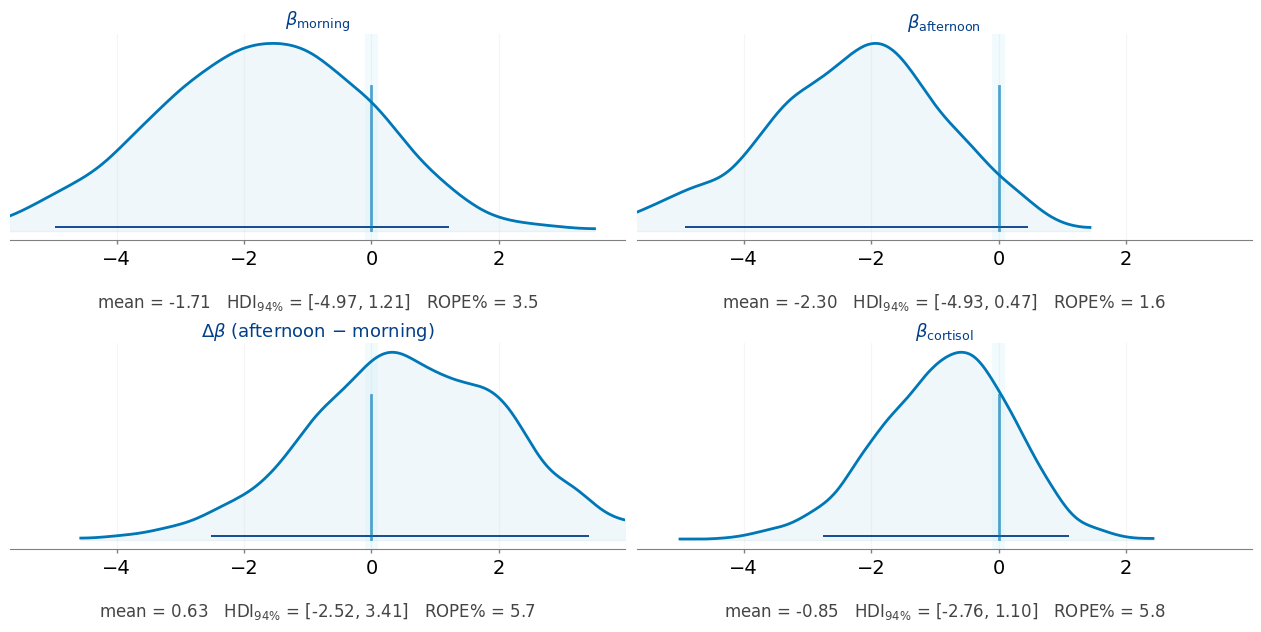

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

FEDERAL_BLUE  = "#023E8A"   
MARIAN_BLUE   = "#0077B6"   
ROPE_FILL     = "#CAF0F8"   
HDI_BAR_COLOR = "#333333"   
TEXT_GRAY     = "#444444"   

vars_plot = ["beta_siga_morning", "beta_siga_afternoon", "beta_siga_diff", "beta_cortisol"]
nice_labels = {
    "beta_siga_morning": r"$\beta_{\mathrm{morning}}$",
    "beta_siga_afternoon": r"$\beta_{\mathrm{afternoon}}$",
    "beta_siga_diff": r"$\Delta\beta$ (afternoon − morning)",
    "beta_cortisol": r"$\beta_{\mathrm{cortisol}}$",
}
hdi = 0.94
rope = (-0.10, 0.10)

idata = trace  

ds = az.extract(idata, var_names=vars_plot, combined=True)
all_vals = np.concatenate([ds[v].values for v in vars_plot])
xmin = float(np.percentile(all_vals, 0.5))
xmax = float(np.percentile(all_vals, 99.5))

fig, axes = plt.subplots(2, 2, figsize=(12.5, 6.2), constrained_layout=True)
axes = axes.ravel()  

for ax, v in zip(axes, vars_plot):
    az.plot_posterior(
        idata, var_names=[v], ax=ax, kind="kde",
        point_estimate="mean", hdi_prob=hdi, ref_val=0.0
    )
    for t in list(ax.texts):
        t.remove()

    for ln in ax.lines:
        if np.isfinite(ln.get_ydata()).any():          
            ln.set_color(MARIAN_BLUE); ln.set_linewidth(2.0)
    if len(ax.lines) >= 2:                              
        ax.lines[-2].set_color(FEDERAL_BLUE); ax.lines[-2].set_linewidth(1.3)

    for col in ax.collections:
        col.set_facecolor(MARIAN_BLUE); col.set_edgecolor(MARIAN_BLUE); col.set_alpha(0.06)

    for l in ax.lines:
        if l.get_linewidth() > 2.5 and (l.get_ydata()==l.get_ydata()[0]).all():
            l.set_color(HDI_BAR_COLOR); l.set_linewidth(3.2)

    ax.axvspan(rope[0], rope[1], color=ROPE_FILL, alpha=0.25, lw=0)

    vals = ds[v].values
    mean = np.mean(vals)
    hdi_low, hdi_high = az.hdi(vals, hdi_prob=hdi)
    pct_in_rope = 100 * np.mean((vals >= rope[0]) & (vals <= rope[1]))
    caption = (fr"mean = {mean:.2f}   "
               fr"HDI$_{{{int(hdi*100)}\%}}$ = [{hdi_low:.2f}, {hdi_high:.2f}]   "
               fr"ROPE% = {pct_in_rope:.1f}")
    ax.text(0.5, -0.25, caption, ha="center", va="top",
            transform=ax.transAxes, color=TEXT_GRAY, fontsize=12)

    ax.set_title(nice_labels.get(v, v), fontsize=13, color=FEDERAL_BLUE, pad=4)
    ax.set_ylabel("")
    ax.set_xlim(xmin, xmax)
    ax.grid(True, axis="x", alpha=0.12)
    ax.spines["right"].set_visible(False); ax.spines["top"].set_visible(False)

fig.savefig("../tmp_figures/bayes_inference_with_cortisol.svg", bbox_inches="tight", dpi=300, transparent=True)
plt.show()



In [7]:
summary = az.summary(
    trace,
    var_names=["beta_cortisol", "beta_siga_morning", "beta_siga_afternoon", "beta_siga_diff"],
    hdi_prob=0.95,
    stat_focus="mean",
    round_to=None
)
